# Create daily global netcdfs


In [1]:
# --- Core data handling and plotting libraries ---
import earthaccess
import xarray as xr       # for working with labeled multi-dimensional arrays
import numpy as np        # for numerical operations on arrays
import pandas as pd
import matplotlib.pyplot as plt  # for creating plots
import cartopy.crs as ccrs
import sklearn
# --- Custom python functions ---
import os, importlib
# Looks to see if you have the file already and if not, downloads from GitHub
if not os.path.exists("ml_utils.py"):
    !wget -q https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/ml_utils.py

import ml_utils as mu
importlib.reload(mu)
# core stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.ndimage import uniform_filter1d

In [2]:
!pip install google-cloud-storage


  Using cached google_cloud_storage-3.7.0-py3-none-any.whl.metadata (14 kB)
  Using cached google_auth-2.43.0-py2.py3-none-any.whl.metadata (6.6 kB)
  Using cached google_api_core-2.28.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached google_cloud_core-2.5.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached google_resumable_media-2.8.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached google_crc32c-1.7.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached googleapis_common_protos-1.72.0-py3-none-any.whl.metadata (9.4 kB)
  Using cached protobuf-6.33.2-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
  Using cached proto_plus-1.26.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
Using cached google_cloud_storage-3.7.0-py3-none-any.whl (303 kB)
Using cached goo

## Read in model

In [3]:
## Load model
bundle = mu.load_ml_bundle("models/brt_chla_profiles_bundle.zip")
brt_models = bundle.model
meta = bundle.meta
rrs_cols = meta["rrs_cols"]
chl_cols = meta["y_col"]
extra = meta["extra_cols"]
dataset = bundle.data["dataset"]
train_idx = bundle.data["train_idx"]
test_idx = bundle.data["test_idx"]
X_train = bundle.data["X_train"]
X_test = bundle.data["X_test"]
y_train_all = bundle.data["y_train"]
y_test_all = bundle.data["y_test"]


Loaded ML bundle from: models/brt_chla_profiles_bundle.zip
  model_kind : pickle
  model_type : collection (dict), n_submodels=20
  example key: CHLA_0_10
  target     : log10_CHLA_A_B depth bins
  features   : 174 columns
  train/test : 4408 / 1102 rows
  dataset    : 5510 rows stored in bundle

Usage example (Python):
  bundle = load_ml_bundle('path/to/bundle.zip')
  # Predict using helper 'predict_all_depths_for_day'
  # Example: predict all depths for one day from a BRF dataset R
  pred = bundle.predict(
      R_dataset,                  # xr.DataArray/xr.Dataset with lat/lon + predictors
      brt_models=bundle.model,    # dict of models by depth bin
      feature_cols=bundle.meta['feature_cols'],
      consts={'solar_hour': 12.0, 'type': 1},
  )  # -> e.g. CHLA(time?, z, lat, lon)

  # Plot using helper 'make_plot_pred_map'
  fig, ax = bundle.plot(pred_da, pred_label='Prediction')



## Create a dataset with our derived variables

In [4]:
import xarray as xr
import numpy as np

def build_chla_profile_dataset(CHLA: xr.DataArray) -> xr.Dataset:
    """
    Given CHLA(time, z, lat, lon), compute derived metrics and
    return an xr.Dataset suitable for writing to Zarr/NetCDF.
    """

    # Start from CHLA's own dataset so its coords (including z_start/z_end) win
    ds = CHLA.to_dataset(name="CHLA")

    # ---- Layer thickness (z dimension) ----
    z_start = CHLA.coords.get("z_start", None)
    z_end   = CHLA.coords.get("z_end", None)

    if (z_start is not None) and (z_end is not None):
        z_thick = (z_end - z_start).rename("z_thickness")   # (z)
    else:
        # fallback: uniform layer thickness, e.g. 10 m
        z_thick = xr.full_like(CHLA["z"], 10.0).rename("z_thickness")

    z_center = CHLA["z"]

    # total CHLA in column (used for validity + center-of-mass)
    col_total = CHLA.sum("z")          # (time, lat, lon)
    valid = col_total > 0              # True where there is some CHLA

    # ---- Integrated CHLA (nominal 0–200 m; actual range = z extent) ----
    CHLA_int = (CHLA * z_thick).sum("z")
    CHLA_int = CHLA_int.where(valid)
    CHLA_int.name = "CHLA_int_0_200"

    # ---- Peak value and depth (NaN-safe) ----
    CHLA_filled = CHLA.fillna(-np.inf)
    peak_idx = CHLA_filled.argmax("z")       # (time, lat, lon) integer indices

    CHLA_peak = CHLA.isel(z=peak_idx).where(valid)
    CHLA_peak.name = "CHLA_peak"

    CHLA_peak_depth = z_center.isel(z=peak_idx).where(valid)
    CHLA_peak_depth.name = "CHLA_peak_depth"

    # ---- Depth-weighted mean depth (center of mass) ----
    num = (CHLA * z_center).sum("z")
    den = col_total
    depth_cm = (num / den).where(valid)
    depth_cm.name = "CHLA_depth_center_of_mass"

    # ---- Attach derived fields to the dataset ----
    ds["CHLA_int_0_200"] = CHLA_int
    ds["CHLA_peak"] = CHLA_peak
    ds["CHLA_peak_depth"] = CHLA_peak_depth
    ds["CHLA_depth_center_of_mass"] = depth_cm
    ds["z_thickness"] = z_thick

    # ---- Variable attributes ----
    # CHLA itself should already have attrs from the prediction step
    ds["CHLA"].attrs.setdefault("units", "mg m-3")
    ds["CHLA"].attrs.setdefault("long_name", "Chlorophyll-a concentration")
    ds["CHLA"].attrs.setdefault(
        "description",
        "BRT-derived chlorophyll-a profiles from PACE hyperspectral Rrs",
    )

    ds["CHLA_int_0_200"].attrs.update(
        units="mg m-2",
        long_name="Depth-integrated chlorophyll-a",
        description=(
            "Vertical integral of CHLA over the available depth bins "
            "(nominally 0–200 m; actual range defined by z_start/z_end)."
        ),
    )

    ds["CHLA_peak"].attrs.update(
        units="mg m-3",
        long_name="Peak chlorophyll-a concentration in the water column",
        description="Maximum CHLA value over depth at each (time, lat, lon).",
    )

    ds["CHLA_peak_depth"].attrs.update(
        units="m",
        long_name="Depth of peak chlorophyll-a",
        positive="down",
        description=(
            "Depth (bin center) where CHLA is maximal in the water column "
            "at each (time, lat, lon)."
        ),
    )

    ds["CHLA_depth_center_of_mass"].attrs.update(
        units="m",
        long_name="Chlorophyll-a depth center of mass",
        positive="down",
        description=(
            "Depth of the chlorophyll-a center of mass, computed as "
            "sum_z(CHLA * z) / sum_z(CHLA)."
        ),
    )

    ds["z_thickness"].attrs.update(
        units="m",
        long_name="Layer thickness",
        description=(
            "Thickness of each vertical bin used for depth integration. "
            "Derived from z_end - z_start when available; otherwise set to a "
            "uniform nominal thickness."
        ),
    )

    # You can still add global ds.attrs later in your pipeline
    return ds

## Test pipeline bits

Get data and make prediction, build dataset. Save a test file to gcs.

In [89]:
# Get some Rrs data
import earthaccess
import xarray as xr

day = "2024-07-08"

auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

# Get Rrs
rrs_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS",
    temporal = (day, day),
    granule_name="*.DAY.*.4km.nc"
)
f = earthaccess.open(rrs_results[0:1], pqdm_kwargs={"disable": True})
rrs_ds = xr.open_dataset(f[0])

lat_min, lat_max = 20, 40
lon_min, lon_max = -70, -60
# Get Rrs for that box
R = rrs_ds["Rrs"].sel(
    lat=slice(lat_max, lat_min),   # decreasing lat coord: max→min
    lon=slice(lon_min, lon_max)
)
pred = bundle.predict(
      R,                  # xr.DataArray/xr.Dataset with lat/lon + predictors
      brt_models=bundle.model,    # dict of models by depth bin
      feature_cols=bundle.meta['feature_cols'],
      consts={'solar_hour': 0, 'type': 1},
  )

Starting 0 of 480
Starting 100 of 480
Starting 200 of 480
Starting 300 of 480
Starting 400 of 480
Starting wrapping
Adding coords


In [ ]:
test_ds = build_chla_profile_dataset(pred)
test_ds

In [98]:
# Test saving file to the bucket
# stop annoying warnings
# https://console.cloud.google.com/storage/browser/nmfs_odp_nwfsc/CB/fish-pace-datasets
import warnings
warnings.filterwarnings("ignore", message="Your application has authenticated using end user credentials")

from google.cloud import storage
from pathlib import Path

# === Set these ===
bucket_name = "nmfs_odp_nwfsc"

# Create client and bucket
client = storage.Client(project="noaa-gcs-public-data")
bucket = client.bucket(bucket_name)

# Set the file you want to test with
test_file = Path("test.pdf")  # change this if using a different file
destination_prefix = "CB/fish-pace-datasets/chla-z/netcdf"

# Create blob and upload
blob_path = f"{destination_prefix}/{test_file.name}"
blob = bucket.blob(blob_path)
blob.upload_from_filename(str(test_file))

print(f"Uploaded {test_file.name} → gs://{bucket_name}/{blob_path}")

Uploaded test.pdf → gs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/test.pdf


## Full pipeline

* dataset to netcdf in google bucket
* Zarr

In [4]:
# Get Rrs data
import earthaccess
import xarray as xr

auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

# Get Rrs
rrs_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS",
    granule_name="*.DAY.*.4km.nc"
)
len(rrs_results)

560

In [ ]:
%%time
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import earthaccess
from google.cloud import storage
import tempfile

# Get Rrs data
import earthaccess
import xarray as xr

auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

# Get Rrs
rrs_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS",
    granule_name="*.DAY.*.4km.nc"
)

# === Set these ===
bucket_name = "nmfs_odp_nwfsc"
# Create client and bucket
client = storage.Client(project="noaa-gcs-public-data")
bucket = client.bucket(bucket_name)
destination_prefix = "CB/fish-pace-datasets/chla-z/netcdf"

lat_chunk = 100
lon_chunk = 100

# just test on first two granules
for res in rrs_results[0:1]:
    # day as ISO string from UMM
    day_iso = res["umm"]["TemporalExtent"]["RangeDateTime"]["BeginningDateTime"]
    day = pd.to_datetime(day_iso)          # Timestamp
    day_str = day.strftime("%Y%m%d")
    print(f"Processing {day_str}...")

    # auth per granule (you can optimize this later if you want)
    auth = earthaccess.login()
    files = earthaccess.open([res], pqdm_kwargs={"disable": True})

    # open dataset
    rrs_ds = xr.open_dataset(files[0])
    # debugging line
    #rrs_ds = rrs_ds.sel(lat=slice(40, 20), lon=slice(-70, -60) )

    try:
        # Rrs for that day
        # (if the file has only one time, squeeze; otherwise select)
        if "time" in rrs_ds.dims:
            R = rrs_ds["Rrs"].sel(time=day).squeeze("time")
        else:
            R = rrs_ds["Rrs"]
        R = R.transpose("lat", "lon", "wavelength")

        # BRT predictions for all depths
        pred = bundle.predict(
            R,
            brt_models=bundle.model,
            feature_cols=bundle.meta["feature_cols"],
            consts={"solar_hour": 0, "type": 1},
            chunk_size_lat=100,
            time=day.to_datetime64(),   # time coord length 1
            z_name="z",
            silent=False,
        )  # (time=1, z, lat, lon), float32

        # Build full dataset with integrated/peak metrics
        ds_day = build_chla_profile_dataset(pred)

        # Add metadata
        ds_day["CHLA"].attrs.update(
            units="mg m-3",
            long_name="Chlorophyll-a concentration",
            description="BRT-derived CHLA profiles from PACE hyperspectral Rrs",
        )
        ds_day["z"].attrs.update(units="m", long_name="depth (bin center)")
        ds_day["lat"].attrs.update(units="degrees_north")
        ds_day["lon"].attrs.update(units="degrees_east")
        ds_day.attrs["source"] = "BRT model trained on BGC-Argo + OOI matchups"
        ds_day.attrs["model_bundle"] = Path("path/to/bundle.zip").name

        # Chunking for NetCDF
        encoding = {
            "CHLA": {
                "dtype": "float32",
                "zlib": True,
                "complevel": 4,
                "chunksizes": (1, ds_day.sizes["z"], lat_chunk, lon_chunk),
            }
            # you can add encodings for derived vars later if desired
        }

        # 4. Write to a local temporary NetCDF, then upload to GCS
        tmp_dir = Path(tempfile.gettempdir())
        local_path = tmp_dir / f"chla_z_{day_str}.nc"
        
        ds_day.to_netcdf(
            local_path,
            engine="h5netcdf",
            encoding=encoding,
        )
        
        blob_path = f"{destination_prefix}/chla_z_{day_str}.nc"
        blob = bucket.blob(blob_path)
        blob.upload_from_filename(str(local_path))
        
        print(f"Wrote {local_path} → gs://{bucket_name}/{blob_path}")
        
    finally:
        rrs_ds.close()
        del ds_day, pred, R, rrs_ds


In [3]:
import xarray as xr
import gcsfs

token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
fs = gcsfs.GCSFileSystem(token=token)

url = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240401.nc"
ds1 = xr.open_dataset(url, engine="h5netcdf", storage_options={"token": token})
ds1

<xarray.Dataset> Size: 4GB
Dimensions:                    (time: 1, z: 20, lat: 4320, lon: 8640)
Coordinates:
  * time                       (time) datetime64[ns] 8B 2024-04-01
  * lat                        (lat) float32 17kB 89.98 89.94 ... -89.94 -89.98
  * lon                        (lon) float32 35kB -180.0 -179.9 ... 179.9 180.0
  * z                          (z) float32 80B 5.0 15.0 25.0 ... 185.0 195.0
    z_start                    (z) float32 80B ...
    z_end                      (z) float32 80B ...
Data variables:
    CHLA                       (time, z, lat, lon) float32 3GB ...
    CHLA_int_0_200             (time, lat, lon) float32 149MB ...
    CHLA_peak                  (time, lat, lon) float32 149MB ...
    CHLA_peak_depth            (time, lat, lon) float32 149MB ...
    CHLA_depth_center_of_mass  (time, lat, lon) float32 149MB ...
    z_thickness                (z) float32 80B ...

In [5]:
%%time
import xarray as xr
import gcsfs

token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
fs = gcsfs.GCSFileSystem(token=token)

pattern = "nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_*.nc"
paths = ["gcs://" + p for p in sorted(fs.glob(pattern))]
print("files:", len(paths), "first:", paths[0])

ds = xr.open_mfdataset(
    paths[0:2],
    engine="h5netcdf",
    combine="by_coords",   # uses the time coordinate in each file
    parallel=True,
    chunks={},             # don't guess chunks yet; we'll rechunk explicitly
)
ds = ds.unify_chunks()
ds = ds.chunk({
    "time": 1,
    "z": -1,
    "lat": 512,
    "lon": 512,
})

files: 560 first: gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305.nc


<timed exec>:11: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.


CPU times: user 8.83 s, sys: 772 ms, total: 9.61 s
Wall time: 32.6 s


In [ ]:
%%time
import xarray as xr
import gcsfs
import dask.array as da

token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
fs = gcsfs.GCSFileSystem(token=token)

pattern = "nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_*.nc"
paths = ["gcs://" + p for p in sorted(fs.glob(pattern))]

chunk_target = {"time": 1, "z": -1, "lat": 512, "lon": 512}

ds = xr.open_mfdataset(
    paths,
    engine="h5netcdf",
    combine="by_coords",
    parallel=False,            # keep stable
    chunks={},                 # ok if you immediately rechunk below
    data_vars="minimal",
    coords="minimal",
    compat="override",
)

# 1) force your desired chunking (creates a rechunk plan if needed)
ds = ds.chunk(chunk_target)

# 2) now make all variables share a consistent chunking
ds = ds.unify_chunks()

In [2]:
%%time
token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"

ds.to_zarr(
    zarr_path,
    mode="w",
    storage_options={"token": token},
)
print("Zarr uploaded:", zarr_path)

/srv/conda/envs/notebook/lib/python3.11/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Zarr uploaded: gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr
CPU times: user 10min 51s, sys: 2min 7s, total: 12min 59s
Wall time: 49min 13s


/srv/conda/envs/notebook/lib/python3.11/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/srv/conda/envs/notebook/lib/python3.11/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [7]:
ds = xr.open_dataset(
    paths[0],
    engine="h5netcdf",
)

In [8]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:                    (time: 1, z: 20, lat: 4320, lon: 8640)
Coordinates:
  * time                       (time) datetime64[ns] 8B 2024-03-05
  * lat                        (lat) float32 17kB 89.98 89.94 ... -89.94 -89.98
  * lon                        (lon) float32 35kB -180.0 -179.9 ... 179.9 180.0
  * z                          (z) float32 80B 5.0 15.0 25.0 ... 185.0 195.0
    z_start                    (z) float32 80B ...
    z_end                      (z) float32 80B ...
Data variables:
    CHLA                       (time, z, lat, lon) float32 3GB ...
    CHLA_int_0_200             (time, lat, lon) float32 149MB ...
    CHLA_peak                  (time, lat, lon) float32 149MB ...
    CHLA_peak_depth            (time, lat, lon) float32 149MB ...
    CHLA_depth_center_of_mass  (time, lat, lon) float32 149MB ...
    z_thickness                (z) float32 80B ...

In [2]:
from pathlib import Path
import numpy as np
import xarray as xr
import gcsfs

token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
fs = gcsfs.GCSFileSystem(token=token)

pattern = "nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_*_v2.nc"
paths = ["gcs://" + p for p in sorted(fs.glob(pattern))]
print("files:", len(paths), "first:", paths[0])

zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"

LAT_CHUNK = 512
LON_CHUNK = 512

# --- helper to open + normalize one day ---
def open_one(path):
    ds = xr.open_dataset(path, engine="h5netcdf", chunks={})
    # normalize time dtype
    if "time" in ds.coords:
        ds = ds.assign_coords(time=ds["time"].astype("datetime64[ns]"))

    # must be exactly one timestep to safely append per file
    if "time" not in ds.dims:
        raise ValueError(f"{path} has no time dimension")
    if ds.sizes["time"] != 1:
        raise ValueError(f"{path} expected time=1, got {ds.sizes['time']}")

    # chunk for zarr write
    ds = ds.chunk({"time": 1, "z": -1, "lat": LAT_CHUNK, "lon": LON_CHUNK})
    return ds

# --- create store from first batch (you already did this) ---
# If you want to keep your 10-file bootstrap, keep it.
# Below assumes zarr already exists and you are appending remaining files.

for i, path in enumerate(paths[10:], start=11):
    ds = open_one(path)
    day = np.datetime_as_string(ds["time"].values[0], unit="D")
    try:
        ds.to_zarr(
            zarr_path,
            mode="a",
            append_dim="time",                 # <-- REQUIRED
            consolidated=False,
            storage_options={"token": token},
        )
        print(f"[{i}/{len(paths)}] appended {day} ({Path(path).name})")
    finally:
        ds.close()


<xarray.Dataset> Size: 2TB
Dimensions:                    (time: 560, z: 20, lat: 4320, lon: 8640)
Coordinates:
  * time                       (time) datetime64[ns] 4kB 2024-03-05 ... 2025-...
  * lat                        (lat) float32 17kB 89.98 89.94 ... -89.94 -89.98
  * lon                        (lon) float32 35kB -180.0 -179.9 ... 179.9 180.0
  * z                          (z) float32 80B 5.0 15.0 25.0 ... 185.0 195.0
    z_start                    (z) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
    z_end                      (z) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
Data variables:
    CHLA                       (time, z, lat, lon) float32 2TB dask.array<chunksize=(1, 20, 512, 512), meta=np.ndarray>
    CHLA_int_0_200             (time, lat, lon) float32 84GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CHLA_peak                  (time, lat, lon) float32 84GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CHLA_peak_depth            (time, lat, lon) float32 84GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    CHLA_depth_center_of_mass  (time, lat, lon) float32 84GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    z_thickness                (z) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>

In [ ]:
%%time
token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr_v1"

ds.to_zarr(
    zarr_path,
    mode="w",
    storage_options={"token": token},
    zarr_format=2,
    consolidated=True
)
print("Zarr uploaded:", zarr_path)

In [ ]:
!pip install gcsfs

In [ ]:
from pathlib import Path
import xarray as xr
import gcsfs
import zarr

token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
fs = gcsfs.GCSFileSystem(token=token)

bucket = "nmfs_odp_nwfsc"
prefix = "CB/fish-pace-datasets/chla-z/netcdf"
pattern = f"{bucket}/{prefix}/chla_z_*.nc"
paths = sorted(fs.glob(pattern))
paths = ["gcs://" + p for p in paths]
print("nfiles:", len(paths), "first:", paths[0])

zarr_path = f"gcs://{bucket}/CB/fish-pace-datasets/chla-z/zarr_v13"

tmp_dir = Path("/tmp/chla_nc_stream")
tmp_dir.mkdir(parents=True, exist_ok=True)

for i, gcs_url in enumerate(paths, 1):
    local_nc = tmp_dir / Path(gcs_url).name

    # Download whole file (single big transfer)
    fs.get(gcs_url, str(local_nc))

    # Open locally (fast)
    ds = xr.open_dataset(local_nc, engine="h5netcdf")

    # Ensure consistent time dtype
    if "time" in ds.coords:
        ds = ds.assign_coords(time=ds["time"].astype("datetime64[ns]"))

    # Rechunk for Zarr (tune lat/lon later)
    chunk_spec = {}
    if "time" in ds.dims: chunk_spec["time"] = 1
    if "z" in ds.dims:    chunk_spec["z"] = ds.sizes["z"]
    if "lat" in ds.dims:  chunk_spec["lat"] = 256
    if "lon" in ds.dims:  chunk_spec["lon"] = 256
    ds = ds.chunk(chunk_spec)

    mode = "w" if i == 1 else "a"

    ds.to_zarr(
        zarr_path,
        mode=mode,
        append_dim="time" if mode == "a" else None,
        consolidated=False,   # consolidate once at end
        zarr_format=2,
        storage_options={"token": token},
    )

    ds.close()
    local_nc.unlink(missing_ok=True)

    print(f"wrote {i}/{len(paths)}")

# consolidate metadata once at end
fs2 = gcsfs.GCSFileSystem(token=token)
store = zarr.storage.FSStore(zarr_path, fs=fs2)
zarr.consolidate_metadata(store)
print("done + consolidated")


In [6]:
from pathlib import Path
import xarray as xr
import gcsfs
import zarr

def process_nc(paths, zarr_path):
    
    token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
    fs = gcsfs.GCSFileSystem(token=token)
           
    tmp_dir = Path("/tmp/chla_nc_stream")
    tmp_dir.mkdir(parents=True, exist_ok=True)
    
    for i, gcs_url in enumerate(paths, 1):
        local_nc = tmp_dir / Path(gcs_url).name
    
        # Download whole file (single big transfer)
        fs.get(gcs_url, str(local_nc))
    
        # Open locally (fast)
        ds = xr.open_dataset(local_nc, engine="h5netcdf")
    
        # Ensure consistent time dtype
        if "time" in ds.coords:
            ds = ds.assign_coords(time=ds["time"].astype("datetime64[ns]"))
    
        # Rechunk for Zarr (tune lat/lon later)
        chunk_spec = {}
        if "time" in ds.dims: chunk_spec["time"] = 1
        if "z" in ds.dims:    chunk_spec["z"] = ds.sizes["z"]
        if "lat" in ds.dims:  chunk_spec["lat"] = 256
        if "lon" in ds.dims:  chunk_spec["lon"] = 256
        ds = ds.chunk(chunk_spec)
    
        mode = "w" if i == 1 else "a"
    
        ds.to_zarr(
            zarr_path,
            mode=mode,
            append_dim="time" if mode == "a" else None,
            consolidated=False,   # consolidate once at end
            zarr_format=2,
            storage_options={"token": token},
        )
    
        ds.close()
        local_nc.unlink(missing_ok=True)
    
        print(f"wrote {i}/{len(paths)}")


Frozen({'lat': 4320, 'lon': 8640, 'z': 20, 'time': 1})

In [33]:
from pathlib import Path
import numpy as np
import xarray as xr
import gcsfs
import time

token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
fs = gcsfs.GCSFileSystem(token=token)

pattern = "nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_*.nc"
paths = ["gcs://" + p for p in sorted(fs.glob(pattern))]
print("files:", len(paths), "first:", paths[0])

zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr_v6"

LAT_CHUNK = 512
LON_CHUNK = 512

# --- helper to open + normalize one day ---
def open_one(path):
    fs = gcsfs.GCSFileSystem(token=token)
    tmp_dir = Path("/tmp/chla_nc_to_zarr_workers")
    tmp_dir.mkdir(parents=True, exist_ok=True)

    local_nc = tmp_dir / Path(path).name
    fs.get(path, str(local_nc))

    ds = xr.open_dataset(local_nc, engine="h5netcdf", chunks={})

    # remove temp file now that it's open
    local_nc.unlink(missing_ok=True)

    ds["z_thickness"] = ds["z_thickness"].expand_dims(time=ds["time"])
    ds = ds.chunk({"time": 1, "z": -1, "lat": LAT_CHUNK, "lon": LON_CHUNK})
    return ds
    
# append exactly one file: paths[10
for i, path in enumerate(paths[0:2], start=1):  # start=10 matches the real index
    ds = open_one(path)
    day = np.datetime_as_string(ds["time"].values[0], unit="D")
    if i == 1:
        ds.to_zarr(
            zarr_path,
            mode="w",
            zarr_format=2,
            storage_options={"token": token},
        )
    else:
        ds.to_zarr(
            zarr_path,
            mode="a",
            append_dim="time",
            zarr_format=2,
            storage_options={"token": token},
        )
    print(time.strftime("%H:%M:%S"), f"[{i}/{len(paths)}] appended {day} ({Path(path).name})")
    ds.close()


files: 560 first: gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305.nc
23:48:09 [1/560] appended 2024-03-05 (chla_z_20240305.nc)
23:48:36 [2/560] appended 2024-03-06 (chla_z_20240306.nc)


In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import gcsfs
import time

token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
fs = gcsfs.GCSFileSystem(token=token)

pattern = "nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_*.nc"
paths = ["gcs://" + p for p in sorted(fs.glob(pattern))]
print("files:", len(paths), "first:", paths[0])

zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr_v6"

LAT_CHUNK = 512
LON_CHUNK = 512

# --- helper to open + normalize one day ---
def open_one(path):
    fs = gcsfs.GCSFileSystem(token=token)
    tmp_dir = Path("/tmp/chla_nc_to_zarr_workers")
    tmp_dir.mkdir(parents=True, exist_ok=True)

    local_nc = tmp_dir / Path(path).name
    fs.get(path, str(local_nc))

    ds = xr.open_dataset(local_nc, engine="h5netcdf", chunks={})

    # remove temp file now that it's open
    local_nc.unlink(missing_ok=True)

    ds["z_thickness"] = ds["z_thickness"].expand_dims(time=ds["time"])
    ds = ds.chunk({"time": 1, "z": -1, "lat": LAT_CHUNK, "lon": LON_CHUNK})
    return ds

def build_chla_profile_dataset(CHLA: xr.DataArray) -> xr.Dataset:
    """
    Given CHLA(time, z, lat, lon), compute derived metrics and
    return an xr.Dataset suitable for writing to Zarr/NetCDF.
    """
    # Start from CHLA's own dataset so its coords (including z_start/z_end) win
    CHLA = 10**CHLA
    ds = CHLA.to_dataset(name="CHLA")

    # ---- Layer thickness (z dimension) ----
    z_start = CHLA.coords.get("z_start", None)
    z_end   = CHLA.coords.get("z_end", None)

    if (z_start is not None) and (z_end is not None):
        z_thick = (z_end - z_start).rename("z_thickness")   # (z)
    else:
        # fallback: uniform layer thickness, e.g. 10 m
        z_thick = xr.full_like(CHLA["z"], 10.0).rename("z_thickness")

    z_center = CHLA["z"]

    # total CHLA in column (used for validity + center-of-mass)
    col_total = CHLA.sum("z")          # (time, lat, lon)
    valid = col_total > 0              # True where there is some CHLA

    # ---- Integrated CHLA (nominal 0–200 m; actual range = z extent) ----
    CHLA_int = (CHLA * z_thick).sum("z")
    CHLA_int = CHLA_int.where(valid)
    CHLA_int.name = "CHLA_int_0_200"

    # ---- Peak value and depth (NaN-safe) ----
    CHLA_filled = CHLA.fillna(-np.inf)
    peak_idx = CHLA_filled.argmax("z")       # (time, lat, lon) integer indices
    peak_idx = peak_idx.compute()               # make it NumPy-backed
    peak_idx = peak_idx.reset_coords(drop=True) # drop lat/lon/time coords from the indexer

    CHLA_peak = CHLA.isel(z=peak_idx).where(valid)
    CHLA_peak.name = "CHLA_peak"

    CHLA_peak_depth = z_center.isel(z=peak_idx).where(valid)
    CHLA_peak_depth.name = "CHLA_peak_depth"

    # ---- Depth-weighted mean depth (center of mass) ----
    num = (CHLA * z_center).sum("z")
    den = col_total
    depth_cm = (num / den).where(valid)
    depth_cm.name = "CHLA_depth_center_of_mass"

    # ---- Attach derived fields to the dataset ----
    ds["CHLA_int_0_200"] = CHLA_int
    ds["CHLA_peak"] = CHLA_peak
    ds["CHLA_peak_depth"] = CHLA_peak_depth
    ds["CHLA_depth_center_of_mass"] = depth_cm
    ds["z_thickness"] = z_thick

    # ---- Attach derived fields to the dataset ----
    ds["CHLA_int_0_200"] = CHLA_int
    ds["CHLA_peak"] = CHLA_peak
    ds["CHLA_peak_depth"] = CHLA_peak_depth
    ds["CHLA_depth_center_of_mass"] = depth_cm
    ds["z_thickness"] = z_thick

    # ---- Variable attributes ----
    ds["CHLA"].attrs.setdefault("units", "mg m-3")
    ds["CHLA"].attrs.setdefault("long_name", "Chlorophyll-a concentration")
    ds["CHLA"].attrs.setdefault("standard_name", "mass_concentration_of_chlorophyll_a_in_sea_water")
    ds["CHLA"].attrs.setdefault(
        "description",
        "BRT-derived chlorophyll-a profiles from PACE hyperspectral Rrs",
    )

    ds["CHLA_int_0_200"].attrs.update(
        units="mg m-2",
        long_name="Depth-integrated chlorophyll-a",
        description=(
            "Vertical integral of CHLA over the available depth bins "
            "(nominally 0–200 m; actual range defined by z_start/z_end)."
        ),
    )

    ds["CHLA_peak"].attrs.update(
        units="mg m-3",
        long_name="Peak chlorophyll-a concentration in the water column",
        standard_name="mass_concentration_of_chlorophyll_a_in_sea_water",
        description="Maximum CHLA value over depth at each (time, lat, lon).",
    )

    ds["CHLA_peak_depth"].attrs.update(
        units="m",
        long_name="Depth of peak chlorophyll-a",
        positive="down",
        description=(
            "Depth (bin center) where CHLA is maximal in the water column "
            "at each (time, lat, lon)."
        ),
    )

    ds["CHLA_depth_center_of_mass"].attrs.update(
        units="m",
        long_name="Chlorophyll-a depth center of mass",
        positive="down",
        description=(
            "Depth of the chlorophyll-a center of mass, computed as "
            "sum_z(CHLA * z) / sum_z(CHLA)."
        ),
    )

    ds["z_thickness"].attrs.update(
        units="m",
        long_name="Layer thickness",
        description=(
            "Thickness of each vertical bin used for depth integration. "
            "Derived from z_end - z_start when available; otherwise set to a "
            "uniform nominal thickness."
        ),
    )

    return ds

files: 1080 first: gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305.nc


In [7]:
from pathlib import PurePosixPath

p = PurePosixPath(paths[21])
stem = p.stem
stem

'chla_z_20240317_v2'

In [10]:
ds = open_one(paths[21])
ds

In [10]:
import gcsfs
token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
fs = gcsfs.GCSFileSystem(token=token)

pattern = "nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_*_v2.nc"
paths_v2 = ["gcs://" + p for p in sorted(fs.glob(pattern))]
pattern = "nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_*.nc"
paths = ["gcs://" + p for p in sorted(fs.glob(pattern))]
print("files:", len(paths), "first:", paths[0])


files: 1092 first: gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305.nc


In [4]:
paths[10]

'gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240317_v2.nc'

In [9]:
ds = xr.open_dataset(paths[21], engine="h5netcdf", chunks={})
ds

/srv/conda/envs/notebook/lib/python3.11/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


<xarray.Dataset> Size: 4GB
Dimensions:                    (time: 1, z: 20, lat: 4320, lon: 8640)
Coordinates:
  * time                       (time) datetime64[ns] 8B 2024-03-17
  * lat                        (lat) float32 17kB 89.98 89.94 ... -89.94 -89.98
  * lon                        (lon) float32 35kB -180.0 -179.9 ... 179.9 180.0
  * z                          (z) float32 80B 5.0 15.0 25.0 ... 185.0 195.0
    z_start                    (z) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
    z_end                      (z) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
Data variables:
    CHLA                       (time, z, lat, lon) float32 3GB dask.array<chunksize=(1, 20, 100, 100), meta=np.ndarray>
    CHLA_int_0_200             (time, lat, lon) float32 149MB dask.array<chunksize=(1, 4320, 8640), meta=np.ndarray>
    CHLA_peak                  (time, lat, lon) float32 149MB dask.array<chunksize=(1, 4320, 8640), meta=np.ndarray>
    CHLA_peak_depth            (time, lat, lon) float32 149MB dask.array<chunksize=(1, 4320, 8640), meta=np.ndarray>
    CHLA_depth_center_of_mass  (time, lat, lon) float32 149MB dask.array<chunksize=(1, 4320, 8640), meta=np.ndarray>
    z_thickness                (time, z) float32 80B dask.array<chunksize=(1, 20), meta=np.ndarray>

In [7]:
%%time
import xarray as xr
ds = xr.open_dataset(paths[11], engine="h5netcdf", chunks={})
lat_chunk = 100; lon_chunk = 100;
ds_day = ds.copy()
ds_day = ds_day.chunk({"time": 1, "z": -1, "lat": lat_chunk, "lon": lon_chunk})
enc4d = dict(dtype="float32", zlib=True, complevel=4,
             chunksizes=(1, ds_day.sizes["z"], lat_chunk, lon_chunk))
enc3d = dict(dtype="float32", zlib=True, complevel=4,
             chunksizes=(1, lat_chunk, lon_chunk))
encoding = {
    "CHLA": enc4d,

    # 3D derived metrics (time, lat, lon)
    "CHLA_int_0_200": enc3d,
    "CHLA_peak": enc3d,
    "CHLA_peak_depth": enc3d,
    "CHLA_depth_center_of_mass": enc3d,
    "z_thickness": dict(dtype="float32", zlib=True, complevel=4, chunksizes=(1, ds_day.sizes["z"])),
}

CPU times: user 785 ms, sys: 216 ms, total: 1 s
Wall time: 5.09 s


In [ ]:
## does not work. needs to go to local file first
import xarray as xr
import fsspec
import json
import os
nc_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/test_v3.nc"
token_path = '/home/jovyan/.config/gcloud/application_default_credentials.json'
storage_options = {'token': token_path}

with fsspec.open(nc_path, mode='w', **storage_options) as f:
    ds_day.to_netcdf(f)

print(f"Successfully wrote data to {nc_path}")

In [33]:
%%time
# Auth for GCS
import gcsfs
fs = gcsfs.GCSFileSystem(token="/home/jovyan/.config/gcloud/application_default_credentials.json")
nc_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr_v2"
ds_day.to_zarr(
    nc_path,
    storage_options={"token": "/home/jovyan/.config/gcloud/application_default_credentials.json"},
    mode="w"
)
print("Zarr uploaded to GCS!")

/srv/conda/envs/notebook/lib/python3.11/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Zarr uploaded to GCS!
CPU times: user 1min 33s, sys: 10.5 s, total: 1min 43s
Wall time: 15min 24s


In [34]:
%%time
local_nc = "test.nc"
ds_day.to_netcdf(local_nc, engine="h5netcdf")
ds2 = xr.open_dataset(local_nc, engine="h5netcdf")
import gcsfs
fs = gcsfs.GCSFileSystem(token="/home/jovyan/.config/gcloud/application_default_credentials.json")
nc_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr_v3"
ds2.to_zarr(
    nc_path,
    storage_options={"token": "/home/jovyan/.config/gcloud/application_default_credentials.json"},
    mode="w"
)
print("Zarr uploaded to GCS!")

/srv/conda/envs/notebook/lib/python3.11/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Zarr uploaded to GCS!
CPU times: user 1min 47s, sys: 16.4 s, total: 2min 4s
Wall time: 5min 12s


In [17]:
%%time
import xarray as xr
ds = xr.open_dataset(paths_v2[10], engine="h5netcdf", chunks={})
lat_chunk = 100; lon_chunk = 100;
ds_day = ds.copy()
ds_day = ds_day.chunk({"time": 1, "z": -1, "lat": lat_chunk, "lon": lon_chunk})
print("Data loaded")


Data loaded
CPU times: user 727 ms, sys: 168 ms, total: 894 ms
Wall time: 3.87 s


In [18]:
ds_day

<xarray.Dataset> Size: 4GB
Dimensions:                    (time: 1, z: 20, lat: 4320, lon: 8640)
Coordinates:
  * time                       (time) datetime64[ns] 8B 2024-03-17
  * lat                        (lat) float32 17kB 89.98 89.94 ... -89.94 -89.98
  * lon                        (lon) float32 35kB -180.0 -179.9 ... 179.9 180.0
  * z                          (z) float32 80B 5.0 15.0 25.0 ... 185.0 195.0
    z_start                    (z) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
    z_end                      (z) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
Data variables:
    CHLA                       (time, z, lat, lon) float32 3GB dask.array<chunksize=(1, 20, 100, 100), meta=np.ndarray>
    CHLA_int_0_200             (time, lat, lon) float32 149MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    CHLA_peak                  (time, lat, lon) float32 149MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    CHLA_peak_depth            (time, lat, lon) float32 149MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    CHLA_depth_center_of_mass  (time, lat, lon) float32 149MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    z_thickness                (time, z) float32 80B dask.array<chunksize=(1, 20), meta=np.ndarray>

In [12]:
paths[0]

'gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305.nc'

In [19]:

# Try time for appending via streaming
import gcsfs
fs = gcsfs.GCSFileSystem(token="/home/jovyan/.config/gcloud/application_default_credentials.json")
nc_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr_v2"
ds_day.to_zarr(
    nc_path,
    storage_options={"token": "/home/jovyan/.config/gcloud/application_default_credentials.json"},
    mode="a",
    append_dim="time",
)
print("Zarr uploaded to GCS!")

/srv/conda/envs/notebook/lib/python3.11/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Zarr uploaded to GCS!


In [ ]:
ds = xr.open_zarr(nc_path)

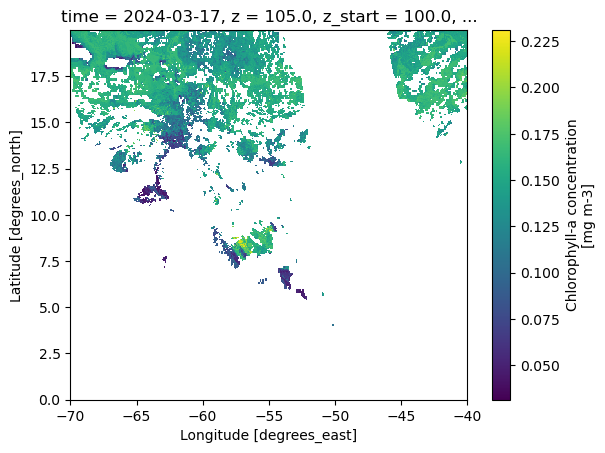

In [21]:
ds["CHLA"].sel(lat=slice(20,0), lon=slice(-70,-40)).isel(z=10).plot()

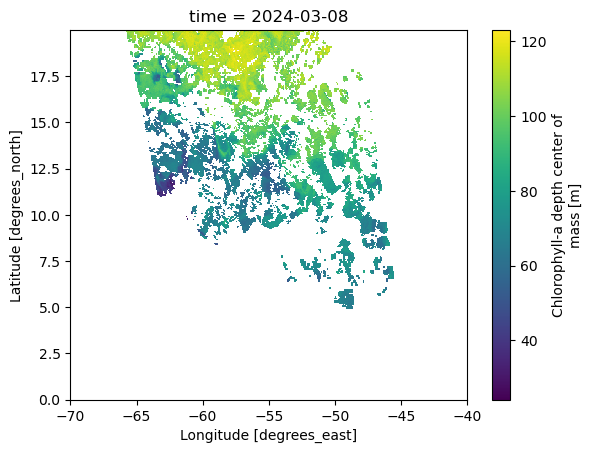

In [7]:
ds["CHLA_depth_center_of_mass"].sel(lat=slice(20,0), lon=slice(-70,-40)).plot()

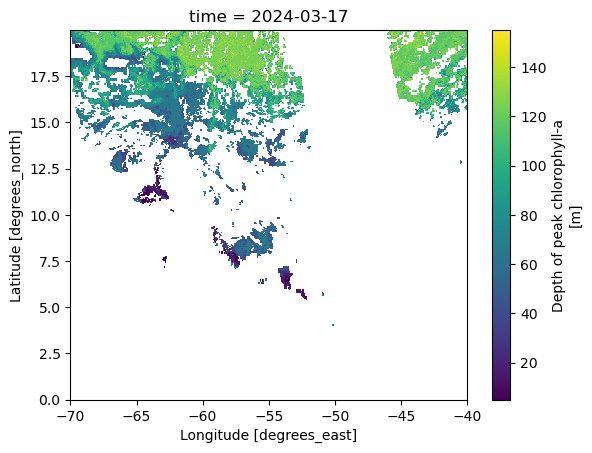

In [12]:
ds["CHLA_peak_depth"].sel(lat=slice(20,0), lon=slice(-70,-40)).plot()

In [3]:
import gcsfs
token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
fs = gcsfs.GCSFileSystem(token=token)
# all .nc
base = "nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf"
all_nc = sorted(fs.glob(f"{base}/chla_z_*.nc"))
# keep only v1 (exclude anything with _v2 anywhere in the name)
paths_v1 = ["gcs://" + p for p in all_nc if "_v2" not in p]
paths_v2 = ["gcs://" + p for p in all_nc if "_v2" in p]
print("files:", len(paths_v1), "first:", paths_v1[0])
print("files:", len(paths_v2), "first:", paths_v2[0])


files: 560 first: gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305.nc
files: 532 first: gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305_v2.nc


In [ ]:
def one_zarr(paths, i):
    import xarray as xr
    import gcsfs
    path = paths[i]
    ds = xr.open_dataset(path, engine="h5netcdf", chunks={})
    lat_chunk = 100; lon_chunk = 100;
    ds_day = ds.copy()
    ds_day = ds_day.chunk({"time": 1, "z": -1, "lat": lat_chunk, "lon": lon_chunk})

    token="/home/jovyan/.config/gcloud/application_default_credentials.json"
    fs = gcsfs.GCSFileSystem(token=token)
    nc_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr_v2"
    if i==0:
        ds_day.to_zarr(
            nc_path,
            storage_options={"token": token},
            mode="w"
        )
    else
        ds_day.to_zarr(
            nc_path,
            storage_options={"token": token},
            mode="a",
            append_dim="time",
        )
    print(f"{i} zarr uploaded to GCS!")
    return None

In [ ]:
from dask.distributed import Client, LocalCluster
import xarray as xr

token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr_v2"

cluster = LocalCluster(n_workers=4, threads_per_worker=1, processes=True)
client = Client(cluster)

lat_chunk = 100
lon_chunk = 100

for i, path in enumerate(paths_v2[10:13]):   # or all of them
    ds = xr.open_dataset(path, engine="h5netcdf", chunks={})
    ds = ds.chunk({"time": 1, "z": -1, "lat": lat_chunk, "lon": lon_chunk})

    mode = "w" if i == 0 else "a"
    kwargs = dict(
        store=zarr_path,
        mode=mode,
        storage_options={"token": token},
    )
    if i > 0:
        kwargs["append_dim"] = "time"

    # This single call will launch many chunk-write tasks on your 4 workers
    ds.to_zarr(**kwargs)

client.close()
cluster.close()


2025-12-18 20:46:15,675 - distributed.diskutils - ERROR - Failed to remove '/tmp/dask-scratch-space/scheduler-1xn8niyy' (failed in <built-in function lstat>): [Errno 2] No such file or directory: '/tmp/dask-scratch-space/scheduler-1xn8niyy'


In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=1, processes=True)

In [23]:
from pathlib import Path
import tempfile
import os

def nc_to_zarr_one(
    path, 
    lat_chunk=100, lon_chunk=100, 
    mode="a"):
    import xarray as xr
    import gcsfs
    from google.cloud import storage
    from datetime import datetime

    zarr_path = "nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr_v2"  # NOTE: no gs:// for GCSMap
    token = "/home/jovyan/.config/gcloud/application_default_credentials.json"

    # download NetCDF locally (HDF5 needs random access; remote streaming is painful)
    fs = gcsfs.GCSFileSystem(token=token_path)
    with tempfile.TemporaryDirectory(prefix="chla_") as td:
        local_nc = Path(td) / Path(path).name
        fs.get(path, str(local_nc))

        ds = xr.open_dataset(
            local_nc,
            engine="h5netcdf",
            chunks={"time": 1, "z": -1, "lat": lat_chunk, "lon": lon_chunk},
        )

        # Use a zarr mapper (NOT fsspec.open(file, 'w') style)
        mapper = gcsfs.GCSMap(zarr_path, gcs=fs, check=False)

        ds.to_zarr(
            store=mapper,
            mode=mode,
            append_dim="time" if mode == "a" else None,
            consolidated=False,
        )

    return f"[{datetime.now():%Y-%m-%d %H:%M:%S}] wrote {path}"


In [ ]:
from dask.distributed import Client
from itertools import repeat

client = cluster.get_client()

# first file creates the store
f0 = client.submit(nc_to_zarr_one, paths_v2[0], mode="w")
print(f0.result())

# rest append
futs = client.map(nc_to_zarr_one, paths_v2[1:])
for f in futs:
    print(f.result())

client.close()


In [22]:
client.close()
cluster.close()

In [25]:
# first file creates the store
f0 = nc_to_zarr_one(paths_v2[0], mode="w")
print(f0)

for path in paths_v2[1:3]:
    f = nc_to_zarr_one(path)
    print(f)


[2025-12-18 21:03:08] wrote gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305_v2.nc
[2025-12-18 21:17:42] wrote gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240306_v2.nc
[2025-12-18 21:33:40] wrote gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240307_v2.nc


In [26]:
nc_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr_v2"
ds = xr.open_zarr(nc_path)

/srv/conda/envs/notebook/lib/python3.11/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/tmp/ipykernel_894/3295906834.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.


In [27]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:                    (time: 1, z: 20, lat: 4320, lon: 8640)
Coordinates:
    z_start                    (z) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
  * lon                        (lon) float32 35kB -180.0 -179.9 ... 179.9 180.0
    z_end                      (z) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
  * z                          (z) float32 80B 5.0 15.0 25.0 ... 185.0 195.0
  * lat                        (lat) float32 17kB 89.98 89.94 ... -89.94 -89.98
  * time                       (time) datetime64[ns] 8B 2024-03-05
Data variables:
    CHLA                       (time, z, lat, lon) float32 3GB dask.array<chunksize=(1, 20, 100, 100), meta=np.ndarray>
    CHLA_depth_center_of_mass  (time, lat, lon) float32 149MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    CHLA_peak                  (time, lat, lon) float32 149MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    z_thickness                (z) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
    CHLA_int_0_200             (time, lat, lon) float32 149MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    CHLA_peak_depth            (time, lat, lon) float32 149MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>